Training Epochs:   0%|          | 0/200000 [00:00<?, ?it/s]

Iteration: 10000. 
Test - Loss: 0.017269134521484375. Accuracy: 100.0
Train -  Loss: 0.018715789541602135. Accuracy: 100.0

Iteration: 20000. 
Test - Loss: 0.009770958684384823. Accuracy: 100.0
Train -  Loss: 0.010402673855423927. Accuracy: 100.0

Iteration: 30000. 
Test - Loss: 0.007096858229488134. Accuracy: 100.0
Train -  Loss: 0.007414252497255802. Accuracy: 100.0

Iteration: 40000. 
Test - Loss: 0.00569169782102108. Accuracy: 100.0
Train -  Loss: 0.005841896869242191. Accuracy: 100.0

Iteration: 50000. 
Test - Loss: 0.004813888110220432. Accuracy: 100.0
Train -  Loss: 0.004860837943851948. Accuracy: 100.0

Iteration: 60000. 
Test - Loss: 0.00420816894620657. Accuracy: 100.0
Train -  Loss: 0.004185526631772518. Accuracy: 100.0

Iteration: 70000. 
Test - Loss: 0.0037620230577886105. Accuracy: 100.0
Train -  Loss: 0.0036896788515150547. Accuracy: 100.0

Iteration: 80000. 
Test - Loss: 0.003418293781578541. Accuracy: 100.0
Train -  Loss: 0.003308994695544243. Accuracy: 100.0

Iteratio

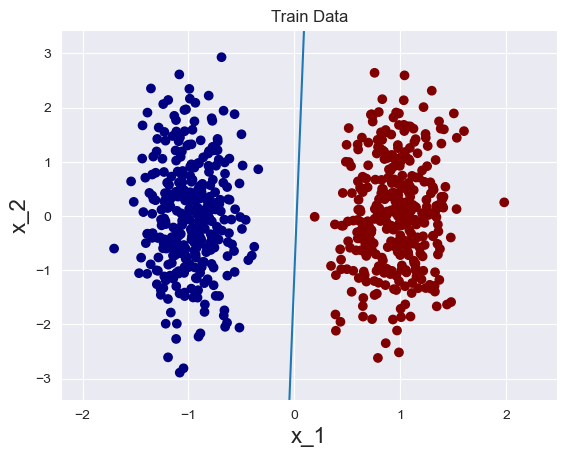

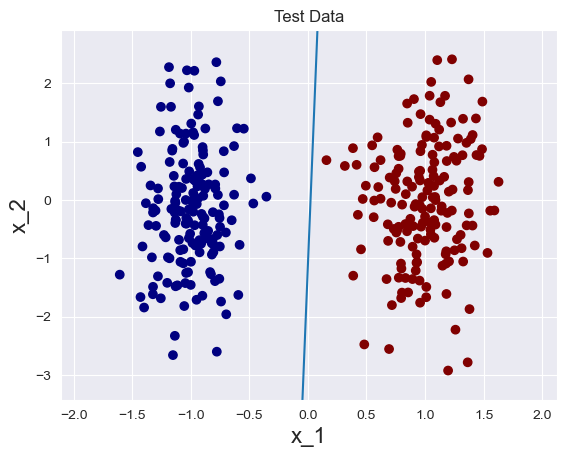

In [1]:
import seaborn as sns
import numpy as np
from sklearn.model_selection import train_test_split
import matplotlib
from tqdm.notebook import tqdm
import torch

# matplotlib.rc('text', usetex=True)
# matplotlib.rcParams['text.latex.preamble']=[r"\usepackage{amsmath}"]
sns.set_style("darkgrid")

from sklearn.datasets import make_classification
import matplotlib.pyplot as plt

separable = False
while not separable:
    samples = make_classification(n_samples=1000, n_features=2, n_redundant=0, n_informative=1, n_clusters_per_class=1, flip_y=-1)
    red = samples[0][samples[1] == 0]
    blue = samples[0][samples[1] == 1]
    separable = any([red[:, k].max() < blue[:, k].min() or red[:, k].min() > blue[:, k].max() for k in range(2)])


red_labels = np.zeros(len(red))
blue_labels = np.ones(len(blue))

labels = np.append(red_labels,blue_labels)
inputs = np.concatenate((red,blue),axis=0)

X_train, X_test, y_train,  y_test = train_test_split(
    inputs, labels, test_size=0.33, random_state=42)

class LogisticRegression(torch.nn.Module):
    def __init__(self, input_dim, output_dim):
        super(LogisticRegression, self).__init__()
        self.linear = torch.nn.Linear(input_dim, output_dim)
        
    def forward(self, x):
        outputs = torch.sigmoid(self.linear(x))
        return outputs

epochs = 200_000
input_dim = 2 # Two inputs x1 and x2 
output_dim = 1 # Two possible outputs
learning_rate = 0.01

model = LogisticRegression(input_dim,output_dim)

criterion = torch.nn.BCELoss()

optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate)

X_train, X_test = torch.Tensor(X_train),torch.Tensor(X_test)
y_train, y_test = torch.Tensor(y_train),torch.Tensor(y_test)

losses = []
losses_test = []
Iterations = []
iter = 0
with tqdm(total=int(epochs),desc='Training Epochs', position=0, leave=True) as pbar:
    for epoch in range(int(epochs)):
        x = X_train
        labels = y_train
        optimizer.zero_grad() # Setting our stored gradients equal to zero
        outputs = model(X_train)
        loss = criterion(torch.squeeze(outputs), labels) # [200,1] -squeeze-> [200]

        loss.backward() # Computes the gradient of the given tensor w.r.t. graph leaves 

        optimizer.step() # Updates weights and biases with the optimizer (SGD)

        iter+=1
        if iter%10000==0:
            # calculate Accuracy
            with torch.no_grad():
                # Calculating the loss and accuracy for the test dataset
                correct_test = 0
                total_test = 0
                outputs_test = torch.squeeze(model(X_test))
                loss_test = criterion(outputs_test, y_test)

                predicted_test = outputs_test.round().detach().numpy()
                total_test += y_test.size(0)
                correct_test += np.sum(predicted_test == y_test.detach().numpy())
                accuracy_test = 100 * correct_test/total_test
                losses_test.append(loss_test.item())

                # Calculating the loss and accuracy for the train dataset
                total = 0
                correct = 0
                total += y_train.size(0)
                correct += np.sum(torch.squeeze(outputs).round().detach().numpy() == y_train.detach().numpy())
                accuracy = 100 * correct/total
                losses.append(loss.item())
                Iterations.append(iter)

                print(f"Iteration: {iter}. \nTest - Loss: {loss_test.item()}. Accuracy: {accuracy_test}")
                print(f"Train -  Loss: {loss.item()}. Accuracy: {accuracy}\n")
        # pbar.set_description(f'Processing {filename}')
        pbar.update(1)


def model_plot(model,X,y,title):
    parm = {}
    b = []
    for name, param in model.named_parameters():
        parm[name]=param.detach().numpy()  
    
    w = parm['linear.weight'][0]
    b = parm['linear.bias'][0]
    plt.scatter(X[:, 0], X[:, 1], c=y,cmap='jet')
    u = np.linspace(X[:, 0].min(), X[:, 0].max(), 2)
    plt.plot(u, (0.5-b-w[0]*u)/w[1])
    plt.xlim(X[:, 0].min()-0.5, X[:, 0].max()+0.5)
    plt.ylim(X[:, 1].min()-0.5, X[:, 1].max()+0.5)
    plt.xlabel('x_1',fontsize=16)
    plt.ylabel('x_2',fontsize=16)
    # plt.xlabel(r'$\boldsymbol{x_1}$',fontsize=16) # Normally you can just add the argument fontweight='bold' but it does not work with latex
    # plt.ylabel(r'$\boldsymbol{x_2}$',fontsize=16)
    plt.title(title)
    plt.show()


# Train Data
model_plot(model,X_train,y_train,'Train Data')

# Test Dataset Results
model_plot(model,X_test,y_test,'Test Data')